### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

import time

from tqdm import tqdm

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = collections.defaultdict(dict)

In [4]:
# Functions to convert state to str and vice versa
def state_to_str(state):
    return f'{state[0]}-{state[1]}-{state[2]}'

def str_to_state(state_str):
    state = [int(i) for i in state_str.split('-')]
    return (state[0], state[1], state[2])

In [5]:
# Functions to convert action to str and vice versa
def action_to_str(action):
    return f'{action[0]}-{action[1]}'

def str_to_action(action_str):
    action = [int(i) for i in action_str.split('-')]
    return (action[0], action[1])

Current state:(2, 0.0, 1), action: (2, 0) 

Current state:(1, 20.0, 0), action: (4, 2) 

Current state:(4, 16.0, 4), action: (2, 1) 

Current state:(2, 19.0, 2), action: (0, 4)

Current state:(2, 22.0, 5), action: (0, 0)


In [6]:
state_action_pairs = [((2, 0, 1), (2, 0)), ((1, 20, 0), (4, 2)), ((4, 16, 4), (2, 1)), ((2, 19, 2), (0, 4)), ((2, 22, 5), (0, 0))]

for state_action in state_action_pairs:
    state = state_action[0]
    action = state_action[1]
    
    state_str = state_to_str(state)
    action_str = action_to_str(action)
    
    States_track[state_str][action_str] = []

In [7]:
def save_tracking_states(agent, env):
    for state_str in States_track.keys():
        for action_str in States_track[state_str].keys():
            state = str_to_state(state_str)
            state_vec = env.state_encod_arch1(state)
            #state_vec.reshape(1, agent.state_vec_size)
            
            action = str_to_action(action_str)
            action_index = env.action_space.index(action)
            
            state_vec = state_vec.reshape(1, len(state_vec))
            qvals = agent.model.predict(state_vec)[0]
            qval = qvals[action_index]
            
            States_track[state_str][action_str].append(qval)

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

5K episodes

In [9]:
Episodes = 5000

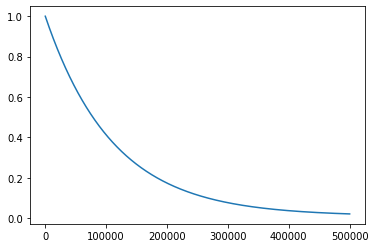

In [11]:
epsilon_max = 1.0
epsilon_min = 0.01
epsilon_decay = -0.000009

avg_timestep_per_episode = 100
episode_n = Episodes

estimated_timesteps = episode_n * avg_timestep_per_episode

timestep_range = np.arange(0,estimated_timesteps)
epsilon = []
for i in range(0,estimated_timesteps):
    epsilon.append(epsilon_min + (epsilon_max - epsilon_min) * np.exp(epsilon_decay*i))
    
plt.plot(timestep_range, epsilon)
plt.show()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    def __init__(self, state_vec_size, action_space_size, epsilon_max, epsilon_min, epsilon_decay):
        # Define size of state and action
        self.state_vec_size = state_vec_size
        self.action_space_size = action_space_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001     
        
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.batch_size = 512
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        # Write your code here: Add layers to your neural nets       
        model = Sequential([
            Dense(64, input_dim=36, activation='relu'),
            Dense(32, activation='relu'),
            Dense(21)  
        ])
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state_vector, time, possible_actions, possible_actions_index):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment    
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(self.epsilon_decay*time)
    
        if np.random.rand() <= epsilon:
            # explore: choose a random action from all possible actions
            # Choose a random action from amongst 21 possible actions
            return random.sample(possible_actions, 1)[0]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_vec_size) so that the first index corresponds to the batch size
            state_vec = state_vector.reshape(1, self.state_vec_size)
            q_value = self.model.predict(state_vec)[0]
            
            q_value_filtered = np.array([q_value[i] for i in possible_actions_index])
            
            q_value_max_index = np.argmax(q_value_filtered)
                        
            return possible_actions[q_value_max_index]
        
    def append_sample(self, state, action, reward, next_state, is_terminal):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, is_terminal))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self, action_space, time):
        
        if len(self.memory) > self.batch_size and time % 50 == 0:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_vec_size))
            update_target = np.zeros((self.batch_size, self.state_vec_size))
            actions, rewards, is_terminals = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, is_terminal = mini_batch[i]
                
                state_encod = env.state_encod_arch1(state)
                next_state_encod = env.state_encod_arch1(next_state)
                
                update_input[i] = state_encod
                actions.append(action)
                rewards.append(reward)
                update_target[i] = next_state_encod
                is_terminals.append(is_terminal)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_target)

            #3. Update your 'update_input' and 'update_target' batch
            for i in range(self.batch_size):
                action = actions[i]
                action_index = action_space.index(action)
                target[i][action_index] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

### DQN block

In [13]:
env = CabDriver()
state_vec_len = len(env.state_encod_arch1(env.state_init))
agent = DQNAgent(state_vec_len, len(env.action_space), epsilon_max, epsilon_min, epsilon_decay)


In [14]:
time_steps = 0
rewards_per_episode = []
episodes = []

start_time = time.time()

time_steps_per_episode = np.zeros(Episodes)

for episode in tqdm(range(Episodes)):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    episode_total_score = 0

    #Call the DQN agent
    # reset at the start of each episode
    (_, _, state, _) = env.reset()

    #print(f'Start Episode:{episode}********')
    
    while not terminal_state:

        # get action for the current state and take a step in the environment
        state_vector = env.state_encod_arch1(state)
        possible_actions_index, possible_actions = env.requests(state)
        action = agent.get_action(state_vector, time_steps, possible_actions, possible_actions_index)
        
        next_state, reward, is_terminal = env.step(state, action, Time_matrix)
        
        #print('-'*100)
        #print(f'Current state:{state}, action: {action}, reward:{reward}, next_state:{next_state}, is_terminal:{is_terminal}')
        # save the sample <s, a, r, s', done> to the replay memory
        agent.append_sample(state, action, reward, next_state, is_terminal)

        # train after each step
        agent.train_model(env.action_space, time_steps)

        # add reward to the total score of this episode
        episode_total_score += reward
        state = next_state
        
        time_steps += 1
        
        terminal_state = is_terminal
        
        time_steps_per_episode[episode] += 1
        
    #print(f'End Episode:{episode}********')
    # store total reward obtained in this episode
    if episode % 25 == 0:
        # Update in memory values after every 25 episodes
        rewards_per_episode.append(episode_total_score)
        episodes.append(episode)
        save_tracking_states(agent, env)
        
    if (episode + 1) % 1000 == 0:
        # After every 1000 episode interval dump data to the disk and also save the model
        save_obj(States_track,'States_tracked')   
        
        agent.save(f'Model-{episode}')
        
    
elapsed_time = time.time() - start_time
print(f'Elapsed time({Episodes} espisodes): {elapsed_time/60} min')
print(f'Average timesteps per episode:{np.average(time_steps_per_episode)}')

100%|██████████| 5000/5000 [2:29:54<00:00,  1.80s/it]  

Elapsed time(5000 espisodes): 149.90184559822083 min
Average timesteps per episode:148.7666


### Tracking Convergence

State-action pair

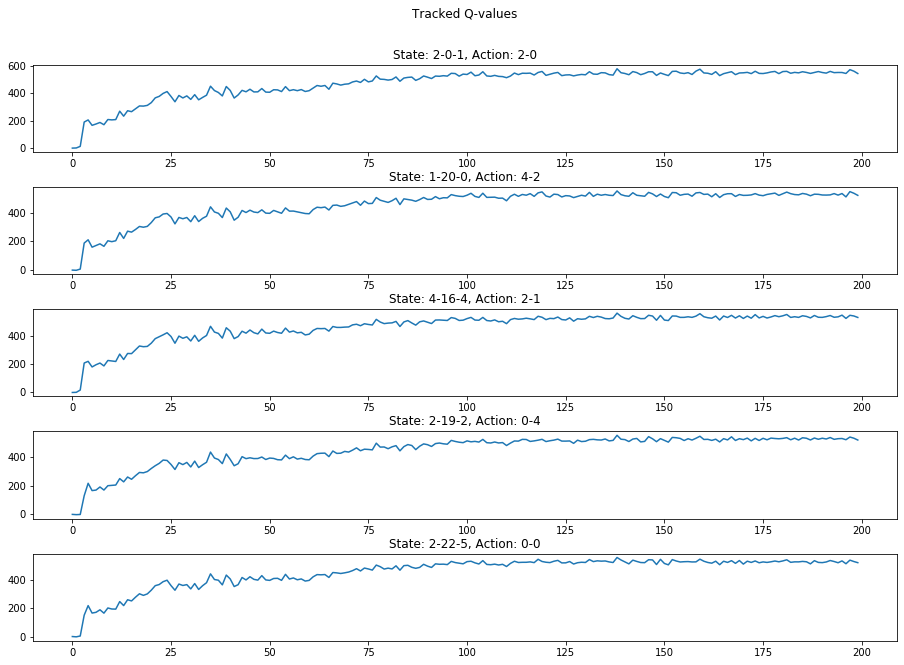

In [16]:
rows = 5
row_num = 0
#episode_numbers = np.arange(threshold, EPISODES + 1, threshold)

fig, ax = plt.subplots(rows,1, figsize=[15,10])


for index, state_str in enumerate(States_track.keys()):
    for action_str in States_track[state_str].keys():
        
        action_values = States_track[state_str][action_str]
        xaxis = np.arange(len(action_values))
        
        ax[row_num].plot(xaxis, action_values)
        ax[row_num].set_title("State: {}, Action: {}".format(state_str, action_str))
        
        row_num += 1
        
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
fig.suptitle('Tracked Q-values')
plt.show()

Rewards

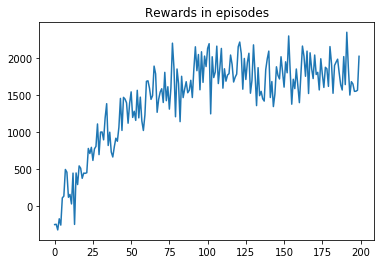

In [17]:
y = rewards_per_episode
x = list(range(0, len(y)))
plt.plot(x,y)
plt.title('Rewards in episodes')
plt.show()